Part Two: Analysis the portfolios in different time horizons

In [1]:
# import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install cvxpy
import cvxpy as cp
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import data
tickers = ["F", "CAT", "DIS","MCD","KO","PEP","WMT","C","WFC","JPM","AAPL","IBM","PFE","JNJ","XOM",
           "MRO","ED","T","VZ","NEM"]
riskfreerate_tickers = "^TYX"

In [4]:
def data (ticker,start_date,end_date): 
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    monthly_data = data["Adj Close"].resample("M").last()
    monthly_returns = (monthly_data.pct_change()*100).dropna()
    mu = monthly_returns.mean()
    std = monthly_returns.std()
    Q = monthly_returns.cov()
    correlation = np.corrcoef(monthly_returns, rowvar=False)
    return mu,std,Q ,monthly_returns,correlation   

In [5]:
def risk_free_rate (riskfreerate_tickers,start_date,end_date):
    risk_free_rate = yf.download(riskfreerate_tickers, start=start_date, end=end_date, progress=False)
    riskFreeRate = risk_free_rate["Adj Close"].resample("M").last()
    riskFreeRate = (riskFreeRate.pct_change()*100).dropna()
    mu_rfr = riskFreeRate.mean()
    return mu_rfr

### Financail Models

#### (1) Mean-variance optimization (MVO)


\begin{equation}
\begin{array}{rl}
\displaystyle \max_{x} & \mu^Tx - λx^TQx \\
{\rm s.t.} & \ 1^Tx = 1\\
\end{array}
\end{equation}

In [6]:
def MVOM(mu, lambda_val, Q):
    n = len(mu)

    # Define the objective function
    def objective(x, mu, Q, lambda_val):
        return -np.dot(mu, x) + lambda_val * np.dot(x.T, np.dot(Q, x))

    # Define the equality constraint function
    def constraint(x):
        return np.sum(x) - 1

    # Define the initial guess for x
    
    x0 = np.random.random(n) 

    # Define the bounds for x variables
    bounds =[(0, None)] * n  

    # Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint}]

    # Solve the optimization problem
    result = minimize(objective, x0, args=(mu, Q, lambda_val), method='SLSQP', constraints=constraints, bounds=bounds)
    x_optimal = result.x

    return np.round(x_optimal, decimals=5)


#### (2) Robust mean-variance optimization 

\begin{equation}
\begin{array}{rl}
\displaystyle \max_{x,y} & \mu^Tx - λx^TQx - a^Ty \\
{\rm s.t.} & \ 1^Tx = 1\\
& y \geq x\\
& y \geq -x\\
\end{array}
\end{equation}

In [7]:
def RMVOM (mu, Q, lambda_val, a): 

    def objective(x, y, mu, Q, lambda_val, a):
        return -(np.dot(mu, x) - lambda_val * np.dot(np.dot(x, Q), x) - np.dot(a, y))

    def constraint1(x):
        return np.sum(x) - 1

    def constraint2(x, y):
        return y - x

    def constraint3(x, y):
        return y + x

# Define the initial guess for x and y
    n = 20  # number of assets
    np.random.seed(123)
    x0 =np.random.random(n)
    y0 = np.random.random(n)

# Define the bounds for x and y variables
    bounds = [(-np.inf, np.inf)] * n

# Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint1},
    {'type': 'ineq', 'fun': constraint2, 'args': (x0,)},
    {'type': 'ineq', 'fun': constraint3, 'args': (x0,)}]

# Solve the optimization problem
    result = minimize(objective, x0, args=(y0, mu, Q, lambda_val, a), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimal solution
    x_optimal = result.x
    
    return np.round(x_optimal, decimals=5)   

#### (3) Risk Parity optimization (with no short selling)

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{x,θ} & \ ∑ (xi(Qx)i - θ)^2  \\
{\rm s.t.} & \ 1^Tx = 1\\
& x \geq 0
\end{array}
\end{equation}

In [8]:
# Define the objective function
def RPM (Q): 
    def objective(x, Q):
        θ = np.mean(x * (Q @ x))
        return np.sum((x * (Q @ x) - θ)**2)

# Define the equality constraint function
    def constraint(x):
        return np.sum(x) - 1

# Define the inequality constraint function
    def inequality_constraint(x):
        return x

# Define the initial guess for x
    n = Q.shape[0]  # Number of assets
    x0 = np.ones(n) / n

# Define the bounds for x variables
    bounds = [(0, None)] * n

# Define the constraints
    constraints = [{'type': 'eq', 'fun': constraint},
               {'type': 'ineq', 'fun': inequality_constraint}]

# Solve the optimization problem
    result = minimize(objective, x0, args=(Q,), method='SLSQP', constraints=constraints, bounds=bounds)

# Extract the optimal solution
    x_optimal = result.x
    θ_optimal = np.mean(x_optimal * (Q @ x_optimal))

    return np.round(x_optimal, decimals=5)    

#### (4)Market Portfolio

In [9]:
# import Market capitalizations of each stock to calculate market wights, market variance and market return 
market_capitalizations = {'AAPL': 2620000000000,'C': 86825000000,'CAT': 109362000000,'DIS': 161332000000,
    'ED': 32121000000,'F': 48369000000,'IBM': 117038000000,'JNJ': 401114000000,'JPM': 400178000000,
    'KO': 260599000000,'MCD': 208836000000,'MRO': 14365000000,'NEM': 32330000000,'PEP': 252916000000,
    'PFE': 212264000000,'T': 110810000000,'VZ': 147140000000,'WFC': 154704000000,'WMT': 394946000000,
    'XOM': 424392000000}
def Market_portfolio (market_capitalizations,Q,mu):
    total_market_cap = sum(market_capitalizations.values())
    weights = np.array([cap / total_market_cap for cap in market_capitalizations.values()])
    wmkt= weights.tolist()
    marketVariance =np.dot(wmkt, np.dot(Q, wmkt))
    marketReturn = np.dot(mu, wmkt)
    return wmkt,marketVariance,marketReturn

#### Part Two: January 2011 to June 2011

In [10]:
def portfolios(weights,mu, cov_matrix):
    portfolio_return= np.sum(mu*weights)
    portfolio_variance = weights.T @ (weights@ cov_matrix)
    portfolio_std = portfolio_variance ** 0.5
    sharpe_ratio =  portfolio_return/portfolio_std
    print ("portfolio_return =" ,portfolio_return,"portfolio_variance=",portfolio_variance,
           "portfolio_std=" ,portfolio_std,"sharpe_ratio=" ,sharpe_ratio)
    return portfolio_return,portfolio_variance,portfolio_std,sharpe_ratio

In [11]:
def data_3 (mu,Q,riskfreerate_2,wmkt,monthly_return,lambda_val,b,b_2): 
    por_weight_1_1 = MVOM(mu,lambda_val,Q)
    por_weight_2_1 = RMVOM (mu, Q, lambda_val, b)
    por_weight_2_2 = RMVOM (mu, Q, lambda_val, b_2)
    por_weight_3 = RPM (Q)
    por_weight_4=np.array(wmkt)
    portfolio_1 = portfolios(por_weight_1_1,monthly_return, Q)
    portfolio_2_1 = portfolios(por_weight_2_1,monthly_return,Q)
    portfolio_2_2 = portfolios(por_weight_2_2,monthly_return,Q)
    portfolio_3 = portfolios(por_weight_3,monthly_return,Q)
    portfolio_market = portfolios(por_weight_4,monthly_return,Q)
    portfolio = pd.DataFrame ({"Return":[portfolio_1[0],portfolio_2_1[0],portfolio_2_2[0],portfolio_3[0],portfolio_market[0]],
                           "Variance":[portfolio_1[1],portfolio_2_1[1],portfolio_2_2[1],portfolio_3[1],portfolio_market[1]],
                           "Standard Deviation":[portfolio_1[2],portfolio_2_1[2],portfolio_2_2[2],portfolio_3[2],portfolio_market[2]],
                           "Sharpe Ratio": [portfolio_1[3],portfolio_2_1[3],portfolio_2_2[3],portfolio_3[3],portfolio_market[3]]})
    portfolio_month = portfolio.rename(index={0: 'Mean Variance',
                                   1:"Robust Mean Varian(90%)",
                                   2:"Robust Mean Varian(95%)",
                                   3: "Risk Parity",
                                   4: "Market"})
    return portfolio_month

In [12]:
start_date = "2010-12-31"
end_date = "2011-07-01"
data_2 = data(tickers,start_date,end_date)
riskfreerate_2 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [13]:
Q2 = data_2[2]
std2 = data_2[1]
mu2 = data_2[0]

In [14]:
market_portfolio = Market_portfolio (market_capitalizations,Q2,mu2)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

In [15]:
λ = (marketReturn-riskfreerate_2)/marketVariance
lambda_val=λ
lambda_val

0.1333739482835388

In [16]:
start_date = "2011-06-29"
end_date = "2011-08-01"
return_July_2011= data (tickers,start_date,end_date)
return_July_2011 = return_July_2011[0]

In [17]:
n=20
b = np.zeros((n, n))
for i in range(n):
    b[i, i] = std2[i] / (6 ** 0.5)
b = 1.6448536269514722* b
b = np.diag(b)
b_2 = 1.96* b

In [18]:
data_Jan_June= data_3(mu2,Q2,riskfreerate_2,wmkt,return_July_2011,lambda_val,b,b_2)
data_Jan_June

portfolio_return = 1.1180341092717476 portfolio_variance= 3.3410853290631986 portfolio_std= 1.8278635969522448 sharpe_ratio= 0.6116616749389521
portfolio_return = -9.436949429873575 portfolio_variance= 6.917516726775648 portfolio_std= 2.630117245823016 sharpe_ratio= -3.5880337444502652
portfolio_return = -9.436949429873575 portfolio_variance= 6.917516726775648 portfolio_std= 2.630117245823016 sharpe_ratio= -3.5880337444502652
portfolio_return = -1.119543342126598 portfolio_variance= 1.5418438875663445 portfolio_std= 1.2417100658230746 sharpe_ratio= -0.9016141311413967
portfolio_return = 5.62937572890909 portfolio_variance= 5.771313864169868 portfolio_std= 2.4023558987314657 sharpe_ratio= 2.3432730062525757


,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,1.118034,3.341085,1.827864,0.611662
Robust Mean Varian(90%),-9.436949,6.917517,2.630117,-3.588034
Robust Mean Varian(95%),-9.436949,6.917517,2.630117,-3.588034
Risk Parity,-1.119543,1.541844,1.241710,-0.901614
Market,5.629376,5.771314,2.402356,2.343273


#### April 2011 to July 2011

In [19]:
start_date = "2011-03-29"
end_date = "2011-08-01"
data3 = data(tickers,start_date,end_date)
riskfreerate_3 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [20]:
start_date = "2011-07-29"
end_date = "2011-09-01"
return_Aug_2011= data (tickers,start_date,end_date)
return_Aug_2011= return_Aug_2011[0]

In [21]:
Q3 = data3[2]
std3 = data3[1]
mu3 = data3[0]

In [22]:
market_portfolio = Market_portfolio (market_capitalizations,Q3,mu3)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

In [23]:
λ = (marketReturn-riskfreerate_3)/marketVariance
lambda_val=λ

In [24]:
c = np.zeros((n, n))
for i in range(n):
    c[i, i] = std3[i] / (4 ** 0.5)
c = 1.6448536269514722* c
c = np.diag(c)
c_2 = 1.96* c

In [25]:
data_April_July = data_3(mu3,Q3,riskfreerate_3,wmkt,return_Aug_2011,lambda_val,c,c_2)
data_April_July

portfolio_return = 3.4734493598738823 portfolio_variance= 0.16410678287683045 portfolio_std= 0.4051009539322642 sharpe_ratio= 8.574280870379456
portfolio_return = 32.529171005626864 portfolio_variance= 1.159972686694464 portfolio_std= 1.0770202814684893 sharpe_ratio= 30.202932633055138
portfolio_return = 32.529171005626864 portfolio_variance= 1.159972686694464 portfolio_std= 1.0770202814684893 sharpe_ratio= 30.202932633055138
portfolio_return = 3.664464375900742 portfolio_variance= 1.6546718053010233e-07 portfolio_std= 0.00040677657323167266 sharpe_ratio= 9008.543306189142
portfolio_return = -1.8313801594607133 portfolio_variance= 12.746511634181187 portfolio_std= 3.5702257119377183 sharpe_ratio= -0.5129592096480485


,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,3.473449,1.641068e-01,0.405101,8.574281
Robust Mean Varian(90%),32.529171,1.159973e+00,1.077020,30.202933
Robust Mean Varian(95%),32.529171,1.159973e+00,1.077020,30.202933
Risk Parity,3.664464,1.654672e-07,0.000407,9008.543306
Market,-1.831380,1.274651e+01,3.570226,-0.512959


#####  May 2011 to August 2011

In [26]:
start_date = "2011-04-27"
end_date = "2011-09-01"
data4 = data(tickers,start_date,end_date)
riskfreerate_4 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [27]:
start_date = "2011-08-29"
end_date = "2011-10-01"
return_Sep_2011= data (tickers,start_date,end_date)
return_Sep_2011 = return_Sep_2011[0]

In [28]:
Q4 = data4[2]
std4 = data4[1]
mu4 = data4[0]

market_portfolio = Market_portfolio (market_capitalizations,Q4,mu4)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

λ = (marketReturn-riskfreerate_4)/marketVariance
lambda_val=λ

d = np.zeros((n, n))
for i in range(n):
    d[i, i] = std4[i] / (4 ** 0.5)
d = 1.6448536269514722* d
d = np.diag(d)
d_2 = 1.96* d

In [29]:
data_May_Aug = data_3(mu4,Q4,riskfreerate_4,wmkt,return_Sep_2011,lambda_val, d,d_2)
data_May_Aug

portfolio_return = -2.716388099982544 portfolio_variance= 0.719329500440114 portfolio_std= 0.8481329497432074 sharpe_ratio= -3.2027857198626646
portfolio_return = 29.128668143553163 portfolio_variance= 1.9847191512180187 portfolio_std= 1.4088006073316475 sharpe_ratio= 20.676217764219025
portfolio_return = 29.128668143553163 portfolio_variance= 1.9847191512180187 portfolio_std= 1.4088006073316475 sharpe_ratio= 20.676217764219025
portfolio_return = -5.861623828198251 portfolio_variance= 2.693179507422014e-07 portfolio_std= 0.0005189585250693946 sharpe_ratio= -11294.975503898777
portfolio_return = -3.9205508530963846 portfolio_variance= 13.923519919760588 portfolio_std= 3.7314233101807934 sharpe_ratio= -1.050685094451647


,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,-2.716388,7.193295e-01,0.848133,-3.202786
Robust Mean Varian(90%),29.128668,1.984719e+00,1.408801,20.676218
Robust Mean Varian(95%),29.128668,1.984719e+00,1.408801,20.676218
Risk Parity,-5.861624,2.693180e-07,0.000519,-11294.975504
Market,-3.920551,1.392352e+01,3.731423,-1.050685


#### June 2011 to September 2011

In [30]:
start_date = "2011-04-29"
end_date = "2011-10-01"
data5 = data(tickers,start_date,end_date)
riskfreerate_5 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [31]:
start_date = "2011-09-29"
end_date = "2011-11-01"
return_Oct_2011= data (tickers,start_date,end_date)
return_Oct_2011=return_Oct_2011[0]

In [32]:
Q5 = data5[2]
std5 = data5[1]
mu5 = data5[0]

market_portfolio = Market_portfolio (market_capitalizations,Q5,mu5)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

λ = (marketReturn-riskfreerate_5)/marketVariance
lambda_val=λ


e = np.zeros((n, n))
for i in range(n):
    e[i, i] = std5[i] / (4 ** 0.5)
e = 1.6448536269514722* e
e = np.diag(e)
e_2 = 1.96* e

data_June_Sep = data_3(mu5,Q5,riskfreerate_5,wmkt,return_Oct_2011,lambda_val,e,e_2)
data_June_Sep

portfolio_return = 3.66617191304924 portfolio_variance= 0.34655233785903183 portfolio_std= 0.5886869608365993 sharpe_ratio= 6.227710407988554
portfolio_return = -20.74304816300115 portfolio_variance= 1.2496078195366063 portfolio_std= 1.1178585865558337 sharpe_ratio= -18.556057458852013
portfolio_return = -20.74304816300115 portfolio_variance= 1.2496078195366063 portfolio_std= 1.1178585865558337 sharpe_ratio= -18.556057458852013
portfolio_return = 4.90964125229492 portfolio_variance= 7.559646308557571e-06 portfolio_std= 0.0027494810980542438 sharpe_ratio= 1785.6610310103172
portfolio_return = 7.375674043147986 portfolio_variance= 13.727937997924533 portfolio_std= 3.7051232095470903 sharpe_ratio= 1.9906690347416487


,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,3.666172,0.346552,0.588687,6.227710
Robust Mean Varian(90%),-20.743048,1.249608,1.117859,-18.556057
Robust Mean Varian(95%),-20.743048,1.249608,1.117859,-18.556057
Risk Parity,4.909641,0.000008,0.002749,1785.661031
Market,7.375674,13.727938,3.705123,1.990669


##### July 2011 to October 2011

In [33]:
start_date = "2011-06-29"
end_date = "2011-11-01"
data6 = data(tickers,start_date,end_date)
riskfreerate_6 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [34]:
start_date = "2011-10-29"
end_date = "2011-12-01"
return_NOv_2011= data (tickers,start_date,end_date)
return_NOv_2011 = return_NOv_2011[0]

In [35]:
Q6 = data6[2]
std6 = data6[1]
mu6 = data6[0]

market_portfolio = Market_portfolio (market_capitalizations,Q6,mu6)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

λ = (marketReturn-riskfreerate_6)/marketVariance
lambda_val=λ


f = np.zeros((n, n))
for i in range(n):
    f[i, i] = std6[i] / (4 ** 0.5)
f = 1.6448536269514722* f
f = np.diag(f)
f_2 = 1.96* f



data_July_Oct = data_3(mu6,Q6,riskfreerate_6,wmkt,return_Oct_2011,lambda_val,f,f_2)
data_July_Oct

portfolio_return = 5.928381008718556 portfolio_variance= 4.24970198736942 portfolio_std= 2.061480532862103 sharpe_ratio= 2.8757880145915102
portfolio_return = 11.62139527367318 portfolio_variance= 1.3622754732683586 portfolio_std= 1.1671655723453973 sharpe_ratio= 9.95693802921226
portfolio_return = 11.62139527367318 portfolio_variance= 1.3622754732683586 portfolio_std= 1.1671655723453973 sharpe_ratio= 9.95693802921226
portfolio_return = 4.411226911867347 portfolio_variance= 5.185557841728522 portfolio_std= 2.277181995741342 sharpe_ratio= 1.937142889815999
portfolio_return = 7.375674043147986 portfolio_variance= 30.554523151135406 portfolio_std= 5.527614598643379 sharpe_ratio= 1.3343321810023023


,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,5.928381,4.249702,2.061481,2.875788
Robust Mean Varian(90%),11.621395,1.362275,1.167166,9.956938
Robust Mean Varian(95%),11.621395,1.362275,1.167166,9.956938
Risk Parity,4.411227,5.185558,2.277182,1.937143
Market,7.375674,30.554523,5.527615,1.334332


In [36]:
df_portolio = pd.DataFrame ({"Month":["July","August","September","October","November"],
                           "Mean_Variance_Return":[data_Jan_June.iloc[0,0],data_April_July.iloc[0,0],
                           data_May_Aug.iloc[0,0],data_June_Sep.iloc[0,0],data_July_Oct.iloc[0,0]],           
                                       
                                       
                           "Robust Mean Varian(90%)_Return":[data_Jan_June.iloc[1,0],data_April_July.iloc[1,0],
                                     data_May_Aug.iloc[1,0],data_June_Sep.iloc[1,0],data_July_Oct.iloc[1,0]],
                           
                           "Robust Mean Varian(95%)_Return":[data_Jan_June.iloc[2,0],data_April_July.iloc[2,0],
                                     data_May_Aug.iloc[2,0],data_June_Sep.iloc[2,0],data_July_Oct.iloc[2,0]],
                                       
                           "Risk Parity_Return":[data_Jan_June.iloc[3,0],data_April_July.iloc[3,0],
                                     data_May_Aug.iloc[3,0],data_June_Sep.iloc[3,0],data_July_Oct.iloc[3,0]], 
                                       
                           "Market Portfolio_Return":[data_Jan_June.iloc[4,0],data_April_July.iloc[4,0],
                            data_May_Aug.iloc[4,0],data_June_Sep.iloc[4,0],data_July_Oct.iloc[4,0]], 
                                      
                                                                  
                           "Mean_Variance_Sharpe Ratio": [data_Jan_June.iloc[0,3],data_April_July.iloc[0,3],
                                     data_May_Aug.iloc[0,3],data_June_Sep.iloc[0,3],data_July_Oct.iloc[0,3]],
                                                                 
                                       
                           "Robust Mean Varian(90%)_Sharpe Ratio":[data_Jan_June.iloc[1,3],data_April_July.iloc[1,3],
                                     data_May_Aug.iloc[1,3],data_June_Sep.iloc[1,3],data_July_Oct.iloc[1,3]],
                           
                           "Robust Mean Varian(95%)_Sharpe Ratio":[data_Jan_June.iloc[2,3],data_April_July.iloc[2,3],
                                     data_May_Aug.iloc[2,3],data_June_Sep.iloc[2,3],data_July_Oct.iloc[2,3]],
                                       
                           "Risk Parity_Sharpe Ratio":[data_Jan_June.iloc[3,3],data_April_July.iloc[3,3],
                                     data_May_Aug.iloc[3,3],data_June_Sep.iloc[3,3],data_July_Oct.iloc[3,3]], 
                                       
                           "Market Portfolio_Sharpe Ratio":[data_Jan_June.iloc[4,3],data_April_July.iloc[4,3],
                            data_May_Aug.iloc[4,3],data_June_Sep.iloc[4,3],data_July_Oct.iloc[4,3]]}) 
df_portolio

,Month,Mean_Variance_Return,Robust Mean Varian(90%)_Return,Robust Mean Varian(95%)_Return,Risk Parity_Return,Market Portfolio_Return,Mean_Variance_Sharpe Ratio,Robust Mean Varian(90%)_Sharpe Ratio,Robust Mean Varian(95%)_Sharpe Ratio,Risk Parity_Sharpe Ratio,Market Portfolio_Sharpe Ratio
0,July,1.118034,-9.436949,-9.436949,-1.119543,5.629376,0.611662,-3.588034,-3.588034,-0.901614,2.343273
1,August,3.473449,32.529171,32.529171,3.664464,-1.831380,8.574281,30.202933,30.202933,9008.543306,-0.512959
2,September,-2.716388,29.128668,29.128668,-5.861624,-3.920551,-3.202786,20.676218,20.676218,-11294.975504,-1.050685
3,October,3.666172,-20.743048,-20.743048,4.909641,7.375674,6.227710,-18.556057,-18.556057,1785.661031,1.990669
4,November,5.928381,11.621395,11.621395,4.411227,7.375674,2.875788,9.956938,9.956938,1.937143,1.334332


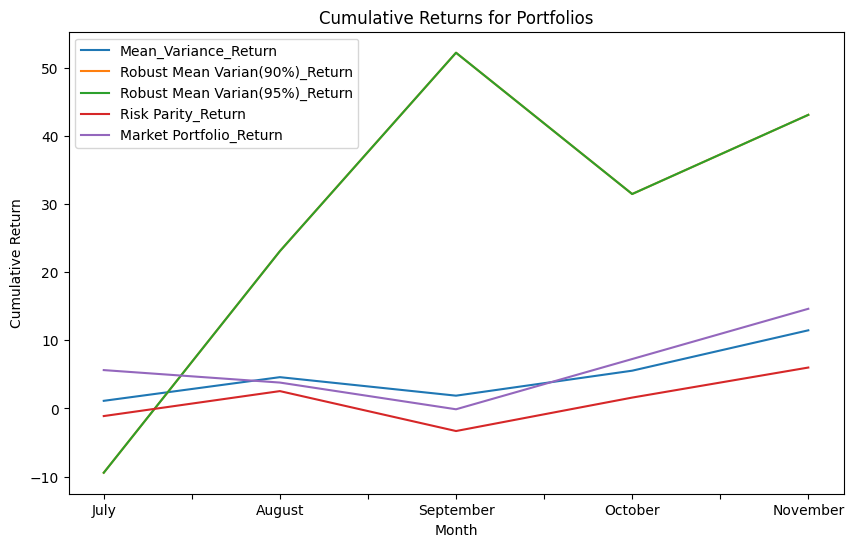

In [37]:
df_return = df_portolio.iloc[:,0:6]
df_return.set_index('Month', inplace=True)  # Set 'Month' as the index

# Calculate cumulative returns for each column
cumulative_returns = df_return.cumsum()

# Plot cumulative returns for each portfolio
fig, ax = plt.subplots(figsize=(10, 6))
cumulative_returns.plot(ax=ax)

# Set plot labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Returns for Portfolios')

# Display the plot
plt.show()

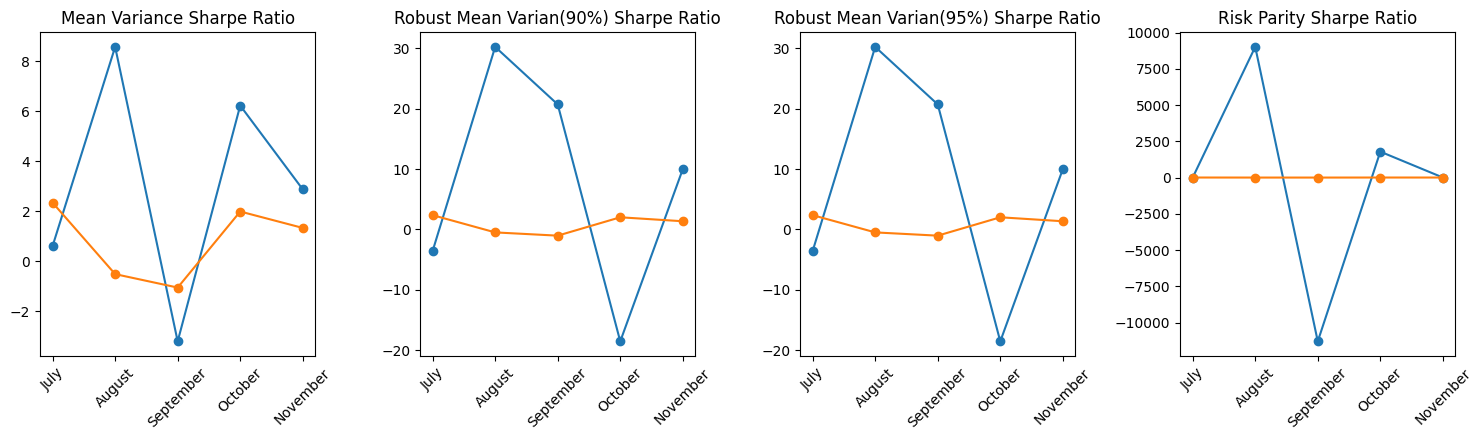

In [44]:
df_sharpe_ratio =df_portolio.iloc[:,6:11]

# Data for Sharpe Ratios
x = ["July", "August", "September", "October", "November"]
y1 = df_sharpe_ratio.iloc[:, 0]
y2 = df_sharpe_ratio.iloc[:, 1]
y3 = df_sharpe_ratio.iloc[:, 2]
y4 = df_sharpe_ratio.iloc[:, 3]
z = df_sharpe_ratio.iloc[:, 4]

# Creating subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# Plotting the lines
axs[0].plot(x, y1, marker='o')
axs[0].plot(x, z, marker='o')
axs[0].set_title('Mean Variance Sharpe Ratio')

axs[1].plot(x, y2, marker='o')
axs[1].plot(x, z, marker='o')
axs[1].set_title('Robust Mean Varian(90%) Sharpe Ratio')

axs[2].plot(x, y3, marker='o')
axs[2].plot(x, z, marker='o')
axs[2].set_title('Robust Mean Varian(95%) Sharpe Ratio')

axs[3].plot(x, y4, marker='o')
axs[3].plot(x, z, marker='o')
axs[3].set_title('Risk Parity Sharpe Ratio')




plt.tight_layout()
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()
